# Polyolefin InfraRed Classification - Preprocessing

In connection with: add DOI INFO/LINK HERE

This code was predominantly produced by Bradley P. Sutliff, with assistance from Tyler B. Martin, and Debra Audus

This notebook is provided in an effort to further open research initiatives and to further the circular economy.

Please direct any questions to Bradley.Sutliff@nist.gov

## Notebook setup

In [1]:
# Change to True if you want to export and save figures
save_figs = False
# Set image type for saving
img_type = "pdf"
# set image style to late refer to our custom matplotlib style sheet
img_style = 'paper'
fig_width = {'single': 8.3/2.54,
             'double': 17.1/2.54} # note, max length is 23.3 cm or 9.17 in

%load_ext autoreload
#remove these two lines in final release
%autoreload 2

### Package Imports

### Define color schemes and plotting dictionaries

In [2]:
# set up notebook for plotting nicely
import matplotlib.pyplot as plt
import pandas as pd

# contxt = "talk"
# sns.set(context=contxt, style="ticks", palette="bright")
style_dict = {'paper':'seaborn-v0_8-paper',
              'talk':'seaborn-v0_8-talk'}
plt.style.use(style_dict[img_style])

pd.options.display.html.use_mathjax = False  # don't render table values as LaTeX
#mpl.rcParams['figure.dpi'] = 300

### Set our color palette to match one of our dictionaries

In [3]:
import Scripts.misc_funcs as misc

cpalette = misc.dict_cBlind

## Data import

### Load data from our files

It is assumed that the data and code are set up in the following directory structure.:
```
Main  
  ├ *.ipynb  
  ├ Data  
  |  ├ SampleInformation.csv  
  |  └ NIR  
  |    ├ N1476LDPE_1.csv  
  |    ├ ...  
  |    └ H0009PP_7.csv  
  └ Scripts  
    ├ *.py  
    ├ *.sh  
    └ *.ps1  
```

First we load the file that has our general sample information

In [4]:
sample_info = pd.read_csv('Data/SampleInformation.csv')
sample_info.tail()

,Source,Sample,Class1,Class2,Physical State,Color,Recycled,Alternate names,bigSMILES,CAS number,Material Keywords,reference URL
40,Commercial Supplier 4,P0051LLDPE,PE,LLDPE,Pellet,Natural,Yes,"`linear low density polyethylene','LLDPE','pol...","{[][$]CC[$],[$]CC({[$][$]C[$][$]}C)[$][]}",9002-88-4,"polyolefins','semicrystalline','copolymer'",NaN
41,Commercial Supplier 3,E0046PP,PP,PP,Pellet,Gray,Yes,"`polypropylene','PP'",{[][$]CC(C)[$][]},9003-07-0,"polyolefins','semicrystalline','linear','homop...",NaN
42,Commercial Supplier 3,E0035PP,PP,PP,Pellet,Black,Yes,"`polypropylene','PP'",{[][$]CC(C)[$][]},9003-07-0,"polyolefins','semicrystalline','linear','homop...",NaN
43,Commercial Supplier 2,C0028PE,PE,NaN,Pellet,Natural,NaN,"`polyethylene', 'PE'",{[][$]CC[$][]},9002-88-4,"polyolefins','semicrystalline','linear','homop...",NaN
44,Commercial Supplier 2,C0079PE,PE,NaN,Pellet,Natural,NaN,"`polyethylene', 'PE'",{[][$]CC[$][]},9002-88-4,"polyolefins','semicrystalline','linear','homop...",NaN


Finally, we can use our file to generate a list of the csvs that hold the spectral data

In [5]:
import itertools
from itertools import product

samples = sample_info.Sample
replicates = [1, 2, 3, 4, 5, 6, 7]
pre_filelist = itertools.product(samples, replicates)
filelist = [
    f"Data/NIR/{'_'.join([fs[0], str(fs[1])])}.csv" for fs in pre_filelist]

Now we can load in each `*.csv` file from our filelist and add it to an Xarray Dataset. When we load it in, we'll also add all of the information from our other 2 files, and we'll add units where necessary.

In [6]:
from tqdm import tqdm
import datetime
import xarray as xr

ds_list = []
for filepath in tqdm(filelist):
    sample = filepath.split('/')[-1].split('.')[0]
    polymer = sample.split('_')[0]
    repeat = sample.split('_')[1].split('.')[0]
    s_info = sample_info.loc[sample_info.Sample == polymer, :]

    # use pandas csv reader to read in file
    dataframe = pd.read_csv(filepath, names=['Wavenumber', 'Intensity'])
    # some files span wider wavelengths than others, so this ensures
    # we are comparing similar ranges of spectra
    dataframe = dataframe.loc[dataframe['Wavenumber'] < 10000, :]

    # convert to Xarray Dataset object
    dataset = dataframe.set_index('Wavenumber').to_xarray()

    # add in extra metadata from filename/filepath
    dataset['polymer'] = str(polymer)
    dataset['sample'] = str(sample)
    dataset['state'] = str(s_info['Physical State'].values[0])
    dataset['repeat'] = int(repeat)
    dataset['Class1'] = str(s_info['Class1'].values[0])
    dataset['Class2'] = str(s_info['Class2'].values[0])
    dataset['Color'] = str(s_info['Color'].values[0])

    # add units where applicable
    dataset['Wavenumber'].attrs = {'units': '1/cm'}
    dataset['Intensity'].attrs = {'units': '% Reflectance'}

    # define global attributes
    dataset.attrs = {'creation_date': datetime.datetime.now().strftime('%Y%m%d'),
                     'author': 'Bradley Sutliff',
                     'email': 'Bradley.Sutliff@nist.gov',
                     'data_collected_by': 'Shailja Goyal'}
    # aggregate data into a list
    ds_list.append(dataset)

ds = xr.concat(ds_list, dim='sample')
ds = ds.set_coords(['sample', 'polymer', 'state',
                   'Class2', 'Class1', 'repeat',
                    'Color'])#, 'Class2_num'])
  
# also saving a copy of this for later use
ds_nopipdims = ds.copy()
# ds['Intensity'] = (ds.Intensity
#                      .assign_coords({"pipeline": "none"})
#                      .expand_dims("pipeline"))

100%|████████████████████████████████████████| 315/315 [00:00<00:00, 355.32it/s]


dropping the samples that are just labeled as "PE"

In [7]:
ds_noClass2 = ds.where(ds.Class2=='nan', drop=True)
ds = ds.where(ds.Class2!='nan', drop=True)

## Raw Data

Take a look at the raw data. This will only plot one of each subclass to keep the plot neat.

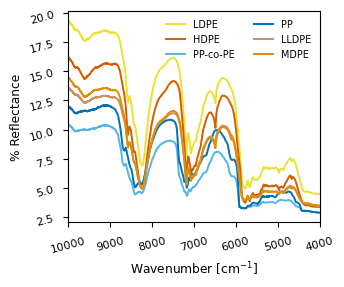

In [8]:
# set info for the plot
plot_name = 'raw_spectra_example'
color_scheme = "Class2"

fig, ax = plt.subplots(figsize=(3.25, 2.75))
# loop through for each poylmer subclass
for ptype in pd.unique(ds[color_scheme].values):
    # grab data of only our chosen subclass
    ds_sub = ds.where(ds[color_scheme] == ptype, drop=True)
    # grab data for a single replicate, the first replicate
    rep_samp = pd.unique(ds_sub.sample.values)[0]
    ds_samp = ds_sub.where(ds_sub.sample == rep_samp, drop=True)

    # grab our x and y values
    x = ds_samp.Wavenumber.values.flatten()
    y = ds_samp.Intensity.values.flatten()
    # use one of our predefined dictionaries to choose a color
    # based on the polymer subclass
    color = cpalette[color_scheme][ptype]

    # add the data to our figure
    plt.plot(x, y, c=color, label=ptype)

# clean up the axis
ax.set_ylabel("% Reflectance")
ax.set_xlabel("Wavenumber [cm$^{-1}$]")
ax.set_xlim(10000, 4000)
# rotate x-ticks for better readability
ax.tick_params(labelrotation=15)
# fix the legend
ax.legend(loc="best", ncol=2, frameon=False, fontsize='x-small')

if save_figs:
    fig.savefig(f'Figures/{plot_name}.{img_type}', dpi=1200, bbox_inches='tight')

## Scatter Corrections (SNV and RNV)

Standard normal variate (SNV) and Robust normal variate (RNV) corrections are common NIR scattering corrections. They correct for scattering artifacts, such as those that arise from differences in pellet or powder shape and size.

In [9]:
from sklearn.preprocessing import FunctionTransformer

# make our transformer to apply the RNV correction
# note: you can change all the RNV/rnv to SNV/snv to apply the standard version
rnv_transformer = FunctionTransformer(misc.xr_RNV, validate=False)
# actually apply the correction and transform our data
ds_rnv = rnv_transformer.fit_transform(ds.Intensity)
ds_rnv.name = 'RNV'
# add this data back to the original Dataset
ds = xr.merge([ds, ds_rnv])

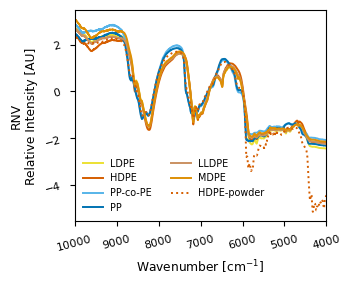

In [10]:
# set info for the plot
correction = 'RNV'
plot_name = f'{correction}_spectra_example'
color_scheme = "Class2"

fig, ax = plt.subplots(figsize=(3.25, 2.75))
for state in pd.unique(ds['state'].values):
    ds_pre_sub = ds.where(ds['state'] == state, drop=True)
    # loop through for each poylmer subclass
    for ptype in pd.unique(ds_pre_sub[color_scheme].values):
        # grab data of only our chosen subclass
        ds_sub = ds_pre_sub.where(ds_pre_sub[color_scheme] == ptype,
                                  drop=True)

        # grab data for a single replicate, the first replicate
        rep_samp = pd.unique(ds_sub.sample.values)[0]
        ds_samp = ds_sub.where(ds_sub.sample == rep_samp,
                               drop=True)

        # grab our x and y values
        x = ds_samp['Wavenumber'].values.flatten()
        y = ds_samp[correction].values.flatten()
        # use one of our predefined dictionaries to choose a color
        # based on the polymer subclass
        color = cpalette[color_scheme][ptype]
        if state == 'Powder':
            ls = ':'
            ptype = f'{ptype}-powder'
        else:
            ls = '-'

        # add the data to our figure
        plt.plot(x, y, c=color, ls=ls, label=ptype)

    # clean up the axis
    ax.set_ylabel(f"{correction}\nRelative Intensity [AU]")
    ax.set_xlabel("Wavenumber [cm$^{-1}$]")
    ax.set_xlim(10000, 4000)

    # fix the legend
    ax.legend(loc="best", ncol=2, frameon=False, fontsize='x-small')
    
    # rotate x-ticks for better readability
    ax.tick_params(labelrotation=15)

if save_figs:
    fig.savefig(f'Figures/{plot_name}.{img_type}', dpi=1200, bbox_inches='tight')

## Detrending

Another possible scattering correction is called detrending. It basically subtracts a linear best-fit line from the data to account for systematic increases in scattering as the wavelenth decreases (wavenumber increases)

In [11]:
# make our transformer to apply the detrending correction
dt_transformer = FunctionTransformer(misc.xr_detrend, validate=False)
# actually apply the correction and transform our data
ds_dt = dt_transformer.fit_transform(ds.RNV)
ds_dt.name = 'RNV-dt'
# add this data back to the original Dataset
ds = xr.merge([ds, ds_dt])

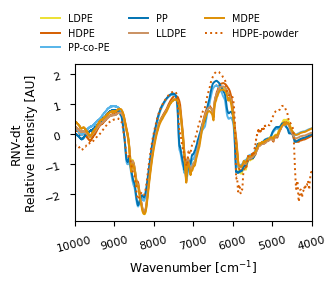

In [12]:
# set info for the plot
correction = 'RNV-dt'
plot_name = f'{correction}_spectra_example'
color_scheme = "Class2"

fig, ax = plt.subplots(figsize=(3.25, 2.75),
                       layout="constrained")
for state in pd.unique(ds['state'].values):
    ds_pre_sub = ds.where(ds['state'] == state, drop=True)
    # loop through for each poylmer subclass
    for ptype in pd.unique(ds_pre_sub[color_scheme].values):
        # grab data of only our chosen subclass
        ds_sub = ds_pre_sub.where(ds_pre_sub[color_scheme] == ptype,
                                  drop=True)

        # grab data for a single replicate, the first replicate
        rep_samp = pd.unique(ds_sub.sample.values)[0]
        ds_samp = ds_sub.where(ds_sub.sample == rep_samp,
                               drop=True)

        # grab our x and y values
        x = ds_samp['Wavenumber'].values.flatten()
        y = ds_samp[correction].values.flatten()
        # use one of our predefined dictionaries to choose a color
        # based on the polymer subclass
        color = cpalette[color_scheme][ptype]
        if state == 'Powder':
            ls = ':'
            ptype = f'{ptype}-powder'
        else:
            ls = '-'

        # add the data to our figure
        plt.plot(x, y, c=color, ls=ls, label=ptype)

    # clean up the axis
    ax.set_ylabel(f"{correction}\nRelative Intensity [AU]")
    ax.set_xlabel("Wavenumber [cm$^{-1}$]")
    ax.set_xlim(10000, 4000)

    # fix the legend
    plt.legend(loc="center", ncol=3, frameon=False,
               bbox_to_anchor=(0.4, 1.2), fontsize='x-small')

    # rotate x-ticks for better readability
    ax.tick_params(labelrotation=15)

if save_figs:
    fig.savefig(f'Figures/{plot_name}.{img_type}', dpi=1200, bbox_inches='tight')

We can see that detrending "flattens out" the data so it so not longer trends downward as we go from left to right.

## Sovitzky-Golay Filtering and Differentiation (SG and SG'')

SG filtering is a common signal smoothing filter. We use it here to clean up some noise, enabling better differentiation. This is also common in the NIR signal processing/chemometric community. However, care should be taken when choosing the parameters of the smoothing (window length and polynomial order).

#### Start by finding a reasonable window size

We are looking for a window of wavelengths where the signal is relatively flat so we can identify the noise in the signal.

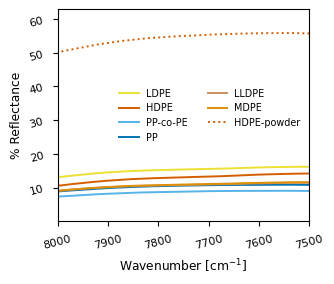

In [13]:
# set info for the plot
fltr = 'SG'
plot_name = f'{fltr}_spectra_example'
color_scheme = "Class2"

fig, ax = plt.subplots(figsize=(3.25, 2.75))
for state in pd.unique(ds['state'].values):
    ds_pre_sub = ds.where(ds['state'] == state, drop=True)
    # loop through for each poylmer subclass
    for ptype in pd.unique(ds_pre_sub[color_scheme].values):
        # grab data of only our chosen subclass
        ds_sub = ds_pre_sub.where(ds_pre_sub[color_scheme] == ptype,
                                  drop=True)

        # grab data for a single replicate, the first replicate
        rep_samp = pd.unique(ds_sub.sample.values)[0]
        ds_samp = ds_sub.where(ds_sub.sample == rep_samp,
                               drop=True)

        # grab our x and y values
        x = ds_samp.Wavenumber.values.flatten()
        y = ds_samp.Intensity.values.flatten()
        # use one of our predefined dictionaries to choose a color
        # based on the polymer subclass
        color = cpalette[color_scheme][ptype]
        if state == 'Powder':
            ls = ':'
            ptype = f'{ptype}-powder'
        else:
            ls = '-'

        # add the data to our figure
        plt.plot(x, y, c=color, ls=ls, label=ptype)

    # clean up the axis
    ax.set_ylabel("% Reflectance")
    ax.set_xlabel("Wavenumber [cm$^{-1}$]")
    ax.set_xlim(8000, 7500)       # <------ Use this line to tune the range, we want to isolate a smooth region
    ax.tick_params(labelrotation=15)
        
    # fix the legend
    ax.legend(loc="best", ncol=2, frameon=False, fontsize='x-small')


The area between 7500 and 7800 looks smooth, so we'll use that to look at the noise in our signal with a fast fourier transform (fft). This basically reduces our data to show what "frequencies" our data varies by. We would expect noise to show up as small, high-frequencies changes while our actual spectra has larger variations at low-frequencies.

In [14]:
import numpy as np

# select our small bit of smooth data
ds_sg_opt = ds.where((ds.Wavenumber<=7800) & (ds.Wavenumber>=7500), drop=True).squeeze()
X = ds_sg_opt.Intensity

# fourier transform the data
X_fft = np.fft.fft(X)
# shift the data so it is zero-centered
# then square it to make it a power spectrum
ps = np.abs(np.fft.fftshift(X_fft))**2

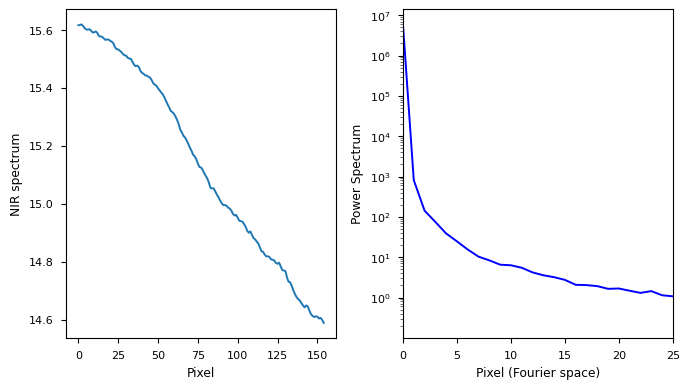

In [15]:
# Define pixel in original signal and Fourier Transform
# this is just the index or the datapoint 
pix = np.array([np.arange(X.shape[1])]*X.shape[0])
fpix = np.array([np.arange(ps.shape[1]) - ps.shape[1]//2]*X.shape[0])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
# choose a "random" sample spectra to look at
i=150
# plot our intensity vs datapoint/pixel
axs[0].plot(pix[i], X[i])
axs[0].set_xlabel('Pixel')
axs[0].set_ylabel('NIR spectrum')

# plot the fourier transform of our data
# this basically visualizes the frequency of changes in our data
# noise in our signal should be much higher frequency (higher pixel in Fourier space)
# than our true signal variations (lower pixel)
axs[1].semilogy(fpix[i], ps[i], 'b')
axs[1].set_xlabel('Pixel (Fourier space)')
axs[1].set_ylabel('Power Spectrum')
axs[1].set_xlim(0,25)
plt.tight_layout()

The majority of our signal variation is below 5 pixels in fourier space, but we don't fully plateau until about 15-20 pixels.
This means that when we smooth our data, we'd like our smoothed function to exactly match our original spectrum from 0 to about 20 pixels.
After 20 pixels, we would like to see some level of smoothing.

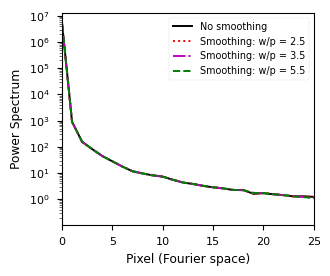

In [16]:
from scipy.signal import savgol_filter

# Set some reasonable parameters to start with
# note: window must be odd and a higher w/p ratio increases smoothing
#       just keep in mind that the larger the window, the more complex
#       a function may have to be to match the data
w = 5
p = 2
# Calculate three different smoothed spectra
X_smooth_1 = savgol_filter(X[i], w, polyorder = p, deriv=0)
X_smooth_2 = savgol_filter(X[i], 2*w+1, polyorder = p, deriv=0)
X_smooth_3 = savgol_filter(X[i], 4*w+1, polyorder = 3*p, deriv=0)
 
# Calculate the power spectra in our featureless region
ps_i = np.abs(np.fft.fftshift(np.fft.fft(X[i])))**2
ps_1 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_1)))**2
ps_2 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_2)))**2
ps_3 = np.abs(np.fft.fftshift(np.fft.fft(X_smooth_3)))**2

 
plt.figure(figsize=(3.25, 2.75))
plt.semilogy(fpix[i], ps_i, 'k-', label = 'No smoothing')
plt.semilogy(fpix[i], ps_1, 'r:', label = 'Smoothing: w/p = 2.5')
plt.semilogy(fpix[i], ps_3, 'm-.', label = 'Smoothing: w/p = 3.5')
plt.semilogy(fpix[i], ps_2, 'g--', label = 'Smoothing: w/p = 5.5')

plt.legend(fontsize='x-small')
plt.xlabel('Pixel (Fourier space)')
plt.ylabel('Power Spectrum')
plt.xlim(0,25)
#plt.ylim(10**0,10**7)

plt.show()

We don't see much change until about 18 or so pixels, which is good. However, w/p = 2.5 (red) follows too closely.
Both magenta and green look very similar though, so either is probably a reasonable choice.

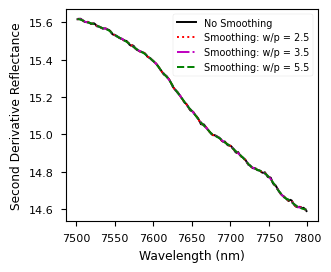

In [17]:
plt.figure(figsize=(3.25, 2.75))
wl = X.Wavenumber
plt.plot(wl, X[i], 'k-', label= 'No Smoothing')
plt.plot(wl, X_smooth_1, 'r:', label = 'Smoothing: w/p = 2.5')
plt.plot(wl, X_smooth_3, 'm-.', label = 'Smoothing: w/p = 3.5')
plt.plot(wl, X_smooth_2, 'g--', label = 'Smoothing: w/p = 5.5')

plt.xlabel("Wavelength (nm)")
plt.ylabel("Second Derivative Reflectance")
plt.legend(fontsize='x-small')
plt.show()


#### Now make an SG filter transformer to apply to the data

In [18]:
# let's make a transformer like we did for RNV so we can apply it to our dataset
# the misc.xr_SG function adapts the regular savgol_filter to work with an xarray dataset 
# we'll use green or w/p = 5.5, our strongest smoothing
sg_transformer = FunctionTransformer(misc.xr_SG, kw_args={'window_length':21, 'polyorder':6}, validate=False)

# make another transformer to apply the Sovitzky-Golay Smoothing w/ 2nd deriv.
sg2_transformer = FunctionTransformer(misc.xr_SG, kw_args={'window_length':21, 'polyorder':6, 'deriv':2}, validate=False)

# actually apply the correction and transform our data
ds_sg = sg_transformer.fit_transform(ds[correction])
ds_sg.name = "SG"
ds_sg2 = sg2_transformer.fit_transform(ds[correction])
ds_sg2.name = "SG2"
# add this data back to the original Dataset
ds = xr.merge([ds, ds_sg, ds_sg2])
ds

<xarray.Dataset>
Dimensions:     (sample: 301, Wavenumber: 3112)
Coordinates:
  * Wavenumber  (Wavenumber) float64 4e+03 4.002e+03 ... 9.997e+03 9.999e+03
    polymer     (sample) <U10 'N1476LDPE' 'N1476LDPE' ... 'E0035PP' 'E0035PP'
  * sample      (sample) <U12 'N1476LDPE_1' 'N1476LDPE_2' ... 'E0035PP_7'
    state       (sample) <U6 'Pellet' 'Pellet' 'Pellet' ... 'Pellet' 'Pellet'
    repeat      (sample) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 4 5 6 7 1 2 3 4 5 6 7
    Class1      (sample) <U2 'PE' 'PE' 'PE' 'PE' 'PE' ... 'PP' 'PP' 'PP' 'PP'
    Class2      (sample) <U8 'LDPE' 'LDPE' 'LDPE' 'LDPE' ... 'PP' 'PP' 'PP' 'PP'
    Color       (sample) <U7 'Natural' 'Natural' 'Natural' ... 'Black' 'Black'
Data variables:
    Intensity   (sample, Wavenumber) float64 4.443 4.447 4.446 ... 4.42 4.433
    RNV         (sample, Wavenumber) float64 -2.443 -2.442 ... 2.467 2.647
    RNV-dt      (sample, Wavenumber) float64 -0.01144 -0.01177 ... -1.264 -1.087
    SG          (sample, Wavenumber) float64 -0.01139 -0.01209 ... -1.074 -1.142
    SG2         (sample, Wavenumber) float64 -0.0001991 -9.898e-05 ... -0.1464
Attributes:
    creation_date:      20240701
    author:             Bradley Sutliff
    email:              Bradley.Sutliff@nist.gov
    data_collected_by:  Shailja Goyal

### What the data looks like now

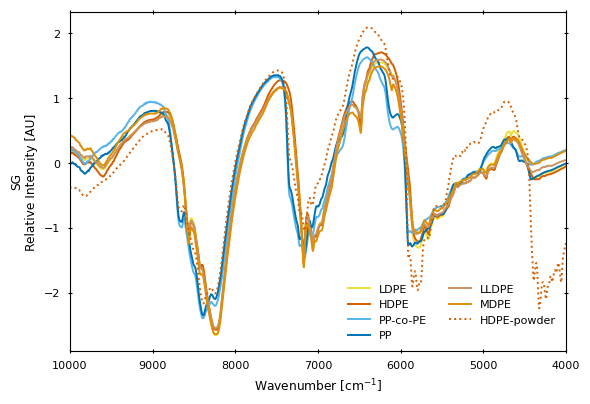

In [19]:
# set info for the plot
color_scheme = "Class2"

fig, ax = plt.subplots()
# loop through the polymer physical states
for state in pd.unique(ds['state'].values):
    ds_pre_sub = ds.where(ds['state'] == state, drop=True)
    # loop through for each poylmer subclass
    for ptype in pd.unique(ds_pre_sub[color_scheme].values):
        # grab data of only our chosen subclass
        ds_sub = ds_pre_sub.where(ds_pre_sub[color_scheme] == ptype,
                                  drop=True)

        # grab data for a single replicate, the first replicate
        rep_samp = pd.unique(ds_sub.sample.values)[0]
        ds_samp = ds_sub.where(ds_sub.sample == rep_samp, drop=True)

        # grab our x and y values
        x = ds_samp.Wavenumber.values.flatten()
        y = ds_samp.SG.values.flatten()
        # use one of our predefined dictionaries to choose a color
        # based on the polymer subclass
        color = cpalette[color_scheme][ptype]
        if state == 'Powder':
            ls = ':'
            ptype = f'{ptype}-powder'
        else:
            ls = '-'

        # add the data to our figure
        plt.plot(x, y, c=color, ls=ls, label=ptype)

# clean up the axis
ax.set_ylabel("SG\nRelative Intensity [AU]")
ax.set_xlabel("Wavenumber [cm$^{-1}$]")
ax.set_xlim(10000, 4000)
ax.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    labelbottom=True,
    labeltop=False,
    labelleft=True,
    labelright=False,
    direction="inout",
)
# fix the legend
ax.legend(loc="best", ncol=2, frameon=False)

### Savitzky-Golay second derivative (SG2 or SG'')

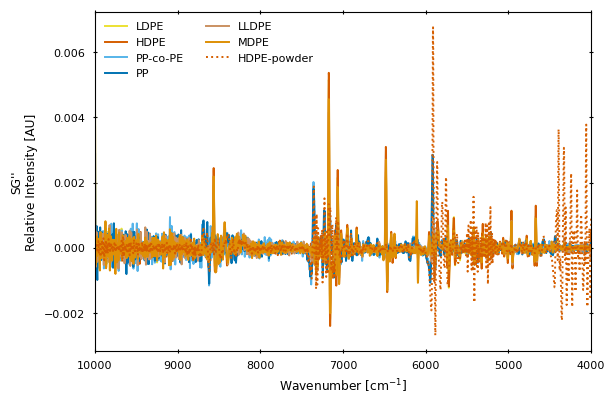

In [20]:
# set info for the plot
color_scheme = "Class2"

fig, ax = plt.subplots()
# loop through the polymer physical states
for state in pd.unique(ds['state'].values):
    ds_pre_sub = ds.where(ds['state'] == state, drop=True)
    # loop through for each poylmer subclass
    for ptype in pd.unique(ds_pre_sub[color_scheme].values):
        # grab data of only our chosen subclass
        ds_sub = ds_pre_sub.where(ds_pre_sub[color_scheme] == ptype,
                                  drop=True)

        # grab data for a single replicate, the first replicate
        rep_samp = pd.unique(ds_sub.sample.values)[0]
        ds_samp = ds_sub.where(ds_sub.sample == rep_samp, drop=True)

        # grab our x and y values
        x = ds_samp.Wavenumber.values.flatten()
        y = ds_samp.SG2.values.flatten()
        # use one of our predefined dictionaries to choose a color
        # based on the polymer subclass
        color = cpalette[color_scheme][ptype]
        if state == 'Powder':
            ls = ':'
            ptype = f'{ptype}-powder'
        else:
            ls = '-'

        # add the data to our figure
        plt.plot(x, y, c=color, ls=ls, label=ptype)

# clean up the axis
ax.set_ylabel("SG''\nRelative Intensity [AU]")
ax.set_xlabel("Wavenumber [cm$^{-1}$]")
ax.set_xlim(10000, 4000)
ax.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    labelbottom=True,
    labeltop=False,
    labelleft=True,
    labelright=False,
    direction="inout",
)
# fix the legend
ax.legend(loc="best", ncol=2, frameon=False)

## Scaling/Normalization

Scaling our data can be fairly important for various machine learning models. It makes it easier for algoriths to comparare based on relative differences rather than on absolute magnitudes. With data like NIR spectra, the peaks and valleys would be likely to washout the variation in the shoulders that might be too subtle if the data is not scaled. 

### Sample Normalization

This step is very similar to what we did with SNV and RNV, it basically scales the entire sample spectra by a factor. In this work we use the L1 norm (Taxicab norm or Manhattan norm) and the L2 norm (Euclidian distance). This effectively rescales each spectra such that:
- L1: the sum of the absolute value of scaled intensities equals 1
- L2: the sum of the squared scaled intensities equals 1

In [21]:
from sklearn_xarray import wrap
from sklearn.preprocessing import Normalizer
# make our transformer to apply the L1 normalization
L1_transformer = wrap(Normalizer(norm='l1'), sample_dim='sample')
L2_transformer = wrap(Normalizer(norm='l2'), sample_dim='sample')
# actually apply the correction and transform our data
ds_L1 = L1_transformer.fit_transform(ds.RNV)
ds_L2 = L2_transformer.fit_transform(ds.RNV)
ds_L1.name = 'RNV-L1'
ds_L2.name = 'RNV-L2'
# add this data back to the original Dataset
ds = xr.merge([ds, ds_L1, ds_L2])

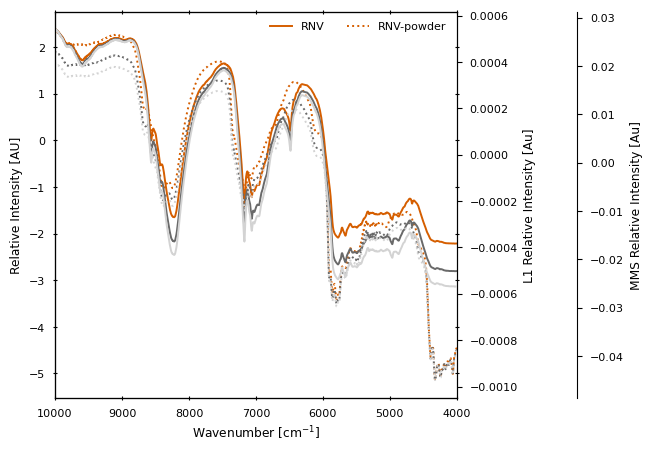

In [22]:
# set info for the plot
color_scheme = "Class2"

fig, ax = plt.subplots(layout='constrained')
ax2 = ax.twinx()
ax3 = ax.twinx()

# loop through the polymer physical states
for state in pd.unique(ds['state'].values):
    ds_pre_sub = ds.where(ds['state'] == state, drop=True)
    # loop through for each poylmer subclass
    #for ptype in pd.unique(ds_pre_sub[color_scheme].values):
    for norm in ['RNV', 'RNV-L1','RNV-L2']:
        # grab data of only our chosen subclass
        ds_sub = ds_pre_sub.where(ds_pre_sub[color_scheme] == 'HDPE',
                                  drop=True)

        # grab data for a single replicate, the first replicate
        rep_samp = pd.unique(ds_sub.sample.values)[0]
        ds_samp = ds_sub.where(ds_sub.sample == rep_samp, drop=True)

        # grab our x and y values
        x = ds_samp.Wavenumber.values.flatten()
        y = ds_samp[norm].values.flatten()
        # use one of our predefined dictionaries to choose a color
        # based on the polymer subclass
        
        if norm == 'RNV':
            color = cpalette[color_scheme]['HDPE']
        if norm == 'RNV-L1':
            color = 'dimgrey'
        if norm == 'RNV-L2':
            color = 'lightgrey'
            
        if state == 'Powder':
            ls = ':'
            norm = f'{norm}-powder'
        else:
            ls = '-'

        # add the data to our figure
        if (norm =='RNV') or (norm == 'RNV-powder'):
            ax.plot(x, y, c=color, ls=ls, label=norm)
        elif (norm =='RNV-L1') or (norm == 'RNV-L1-powder'):
            ax2.plot(x, y, c=color, ls=ls, label=norm)
        else:
            ax3.plot(x, y, c=color, ls=ls, label=norm)
# clean up the axis
ax.set_ylabel("Relative Intensity [AU]")
ax2.set_ylabel("L1 Relative Intensity [Au]")
ax3.set_ylabel("MMS Relative Intensity [Au]")
ax3.spines['right'].set_position(('axes', 1.3))

ax.set_xlabel("Wavenumber [cm$^{-1}$]")
ax.set_xlim(10000, 4000)
ax.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    labelbottom=True,
    labeltop=False,
    labelleft=True,
    labelright=False,
    direction="inout",
)
# fix the legend
ax.legend(loc="best", ncol=2, frameon=False)

Notice how similar the data is for each normalization (or lack of), but the scales change drastically.

### Feature Normalization

Feature normalization works along the other axis. Instead of scaling each spectra (row), it scales the intensities for a given wavenumber/feature (column).
- [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler): Same as SNV, but applied to the column
- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Linearly scales the data between 0 and 1

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# make our transformer to apply the Feature normalization
SS_transformer = wrap(StandardScaler(), sample_dim='sample')
MMS_transformer = wrap(MinMaxScaler(), sample_dim='sample')
# actually apply the correction and transform our data
ds_SS = SS_transformer.fit_transform(ds.RNV)
ds_MMS = MMS_transformer.fit_transform(ds.RNV)
ds_SS.name = 'RNV-SS'
ds_MMS.name = 'RNV-MMS'
# add this data back to the original Dataset
ds = xr.merge([ds, ds_SS, ds_MMS])

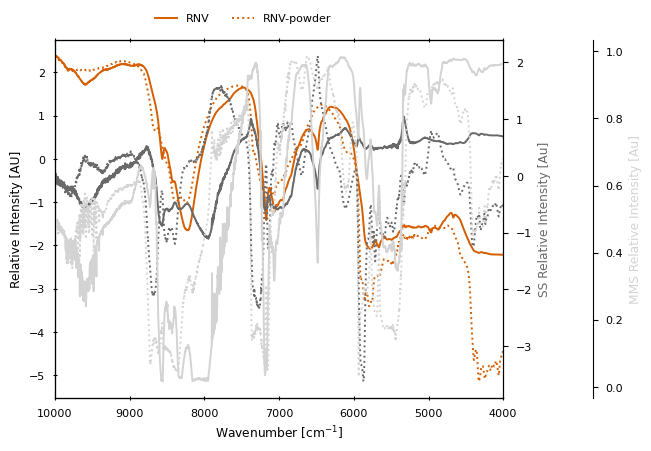

In [24]:
# set info for the plot
color_scheme = "Class2"

fig, ax = plt.subplots(layout='constrained')
ax2 = ax.twinx()
ax3 = ax.twinx()

# loop through the polymer physical states
for state in pd.unique(ds['state'].values):
    ds_pre_sub = ds.where(ds['state'] == state, drop=True)
    # loop through for each poylmer subclass
    #for ptype in pd.unique(ds_pre_sub[color_scheme].values):
    for norm in ['RNV', 'RNV-SS','RNV-MMS']:
        # grab data of only our chosen subclass
        ds_sub = ds_pre_sub.where(ds_pre_sub[color_scheme] == 'HDPE',
                                  drop=True)

        # grab data for a single replicate, the first replicate
        rep_samp = pd.unique(ds_sub.sample.values)[0]
        ds_samp = ds_sub.where(ds_sub.sample == rep_samp, drop=True)

        # grab our x and y values
        x = ds_samp.Wavenumber.values.flatten()
        y = ds_samp[norm].values.flatten()
        # use one of our predefined dictionaries to choose a color
        # based on the polymer subclass
        
        if norm == 'RNV':
            color = cpalette[color_scheme]['HDPE']
        if norm == 'RNV-SS':
            color = 'dimgrey'
        if norm == 'RNV-MMS':
            color = 'lightgrey'
            
        if state == 'Powder':
            ls = ':'
            norm = f'{norm}-powder'
        else:
            ls = '-'

        # add the data to our figure
        if (norm =='RNV') or (norm == 'RNV-powder'):
            ax.plot(x, y, c=color, ls=ls, label=norm)
        elif (norm =='RNV-SS') or (norm == 'RNV-SS-powder'):
            ax2.plot(x, y, c=color, ls=ls, label=norm)
        else:
            ax3.plot(x, y, c=color, ls=ls, label=norm)
# clean up the axis
ax.set_ylabel("Relative Intensity [AU]")
ax2.set_ylabel("SS Relative Intensity [Au]")
ax2.yaxis.label.set_color('dimgrey')
ax3.set_ylabel("MMS Relative Intensity [Au]")
ax3.spines['right'].set_position(('axes', 1.2))
ax3.yaxis.label.set_color('lightgrey')

ax.set_xlabel("Wavenumber [cm$^{-1}$]")
ax.set_xlim(10000, 4000)
ax.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=False,
    labelbottom=True,
    labeltop=False,
    labelleft=True,
    labelright=False,
    direction="inout",
)
# fix the legend
ax.legend(loc="upper left", ncol=2, frameon=False,  bbox_to_anchor=(0.2, 1.1))

Feature scaling has a much more drastic effect, but the scales remain similar

## Data Reduction

In [25]:
import umap

# make our transformer to apply the Feature normalization
pca_transformer = misc.my_PCA(n_components=0.99, min_n_components=5)
# note: I am only applying PCA since fPCA and PCA yield functionally identical results in most cases.
# they have important differences if you want to take advantage of the loading functions rather than the vectors
# but we are not doing that.
umap_transformer = wrap(umap.UMAP(n_components=5), sample_dim='sample',
                           reshapes='Wavenumber')
# actually apply the correction and transform our data
ds_pca = pca_transformer.fit_transform(ds.RNV)
ds_umap = umap_transformer.fit_transform(ds.RNV)
ds_pca.name = 'RNV-pca'
ds_umap.name = 'RNV-umap'
ds_umap = xr.DataArray(data = ds_umap,
                       dims = ["sample", "feature"],
                       coords = {"sample": ds_umap.sample.values,
                                 "feature": np.arange(ds_umap.shape[1]),
                                })
# add this data back to the original Dataset
ds = xr.merge([ds, ds_pca])
ds = xr.merge([ds, ds_umap])

2it [00:00, 122.57it/s]


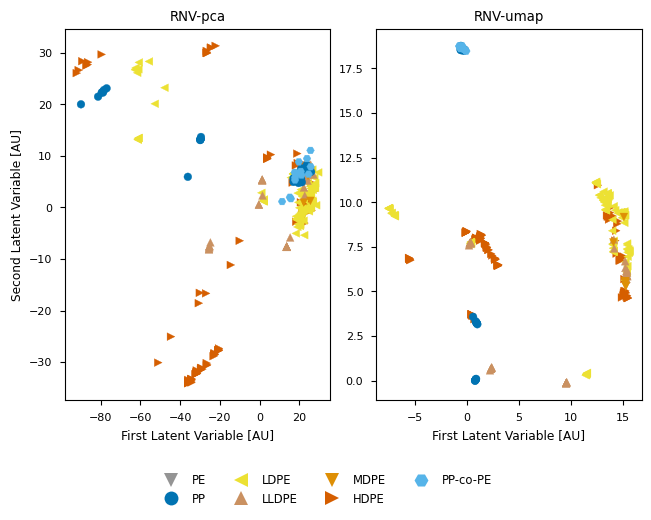

In [26]:
from matplotlib.lines import Line2D

color_scheme = 'Class2'

plot_name = f'pca-umap_comparison'


import math
fig, axs = plt.subplots(ncols=2, nrows=1,
                       layout='constrained')
for i, pipe in tqdm(enumerate(['RNV-pca', 'RNV-umap'])):
  
    ds_plot = ds[pipe]
    
    try:
        ax = axs.flatten()[i]
    except:
        ax = axs
        
    x = ds_plot[:, 0].values
    y = ds_plot[:, 1].values

    ax.set_title(pipe)
    col_vec = pd.Series(ds_plot[color_scheme]
                        .values).map(cpalette[color_scheme])
    shape_vec = pd.Series(ds_plot[color_scheme]
                          .values).map(misc.dict_shapes[color_scheme])
    order = np.argsort(ds_plot[color_scheme].values)

    # add the data
    # note: fix_markers is a custom function
    myscatter = ax.scatter(x[order], y[order],
                           color=col_vec.values[order])
    misc.fix_markers(myscatter, shape_vec.values[order])
    ax.set_xlabel('First Latent Variable [AU]')

axs[0].set_ylabel('Second Latent Variable [AU]')

leg_elems = [Line2D([0], [0],
                    marker=misc.dict_shapes[color_scheme][key],
                    color='w',
                    markerfacecolor=cpalette[color_scheme][key],
                    label=key, markersize=10)
             for key in misc.dict_colors[color_scheme].keys()]
fig.legend(handles=leg_elems,
           loc='center', bbox_to_anchor=[0.5, -0.1],
           fontsize='small',
           ncol=math.ceil(len(leg_elems)/2),
           frameon=False)

plt.show()

## Conclusions

We now have all the tools to apply the corrections on our data and an idea of what each option does to the data. We can use these in a number of combinations to generate our preprocessing steps. To replicate the results in our manuscript, you can create a loop to apply all combinations of these corrections on the data (see notebook 2)